In [50]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt

In [53]:
def solar_radiation(date, lat, lon, azim, inclin, sc=1353.):
    """ Based on subroutine solar from C.D. Whiteman and K.J. Allwine
    
    Calculates extraterrestial solar radiation at a requested time of the day
    on a slope of any azimuth and inclination angle given the latitude and
    longitude, date and slope azimuth and inclination angles.
    
    Notes:
        The original Fortran version has been slightly modified
    
    Args:
        date (datetime) : Date : datetime(2012,7,6,12,0)
        lat (float)     : Latitude : -90 - 90
        lon (float)     : Longitude : 0 - 360
        azim (float)    : Slope Azimuth : 0-360
        inclin (float)  : Slope Inclination : 0 - 90
    
    Keyword Args:
        sc (float)      : Solar Constant (W/m2)
        
    Results:
        tuple : radiation, azimuth, zenith
        
        Solar Radiation in W/m2
        Solar Azimuth angle in deg
        Solar Zenith angle in deg
    """
    # constants defined by whiteman
    acof = np.array([.00839, -.05391, -.00154, -.00222])
    bcof = np.array([-.12193, -.15699, -.00657, -.00370])
    dzero=80.
    ecc=.0167
    pi=3.14159
    degrad=pi/180.
    decmax=(23.+(26./60.))*degrad
    omega=(2.*pi)/365.
    onehr=15.*degrad
    
    # Day of the YEAR
    julday = date.timetuple().tm_yday
    # radius vector squared
    omd=omega*julday
    omdzero=omega*dzero
    rvs=1./(1.-(ecc*np.cos(omd)))**2
    # declination of sun
    longsun=omega*(julday-dzero)+2.*ecc*(np.sin(omd)-np.sin(omdzero))
    declin=np.arcsin(np.sin(decmax)*np.sin(longsun))
    sdec=np.sin(declin)
    cdec=np.cos(declin)
    # Sun rise hour angle
#     arg = ((pi/2.) - np.abs(declin)) / degrad
#     if np.abs(lat) > arg:
#         if (lat > 0 and declin < 0) or (lat<0 and declin > 0):
#             return 0.,0.,0.
#         sr = -pi
#     else:
#         sr = -np.abs(np.arcos(-np.tan(lat*degrad)*tan(declin)))
        
    # standard time meridian for site
    stdmrdn = np.round(lon/15.)*15
    longcor = (lon-stdmrdn)/15.

    # time correction from equation of time
    B = np.arange(1,5) * 2.*pi*(julday-.4)/365.
    em = bcof * np.sin(B) + acof * np.cos(B)
    em = np.sum(em)
    
    # time of solar noon
    timnoon=12.-em-longcor
    
    # convert degrees to radians, sets up values for radiation calculation
    azimslo=azim*degrad
    inslo=inclin*degrad
    slat=np.sin(lat*degrad)
    clat=np.cos(lat*degrad)
    cazim=np.cos(azimslo)
    sazim=np.sin(azimslo)
    cinc=np.cos(inslo)
    sinc=np.sin(inslo)
    
    # Time 
    hrdec = date.hour + date.minute/60.
    
    # calculates incoming solar radiation at each timestep
    H=onehr*(hrdec-timnoon)
    cosz=slat*sdec+clat*cdec*np.cos(H)
    cosbeta=cdec*((slat*np.cos(H))*(-cazim*sinc)-np.sin(H)*(sazim*sinc)+(clat*np.cos(H))*cinc) + sdec*(clat*(cazim*sinc)+slat*cinc)
    extslo=sc*rvs*cosbeta
    extra=sc*rvs*cosz
    if (extslo < 0.) or (extra <= 0.) :
        extslo = 0.
    
    Z = np.arccos(cosz)
    cosa = (slat*cosz- sdec)/(clat*np.sin(Z))
    cosa = -1. if cosa < -1. else cosa
    cosa = 1. if cosa > 1. else cosa
    a = np.abs(np.arccos(cosa))
    a = -a if H < 0. else a
    
    # radiation (W/m2), solar azimuth (deg), solar zenith (deg)
    return extslo,  a/degrad + 180., Z/degrad 

In [54]:
print solar_radiation(datetime(2012,12,22,12,0), 30,0 ,90, 0)  # UTC
print solar_radiation(datetime(2012,12,22,9,0), 30,0 ,90, 0)

(833.4732203490571, 180.35135236450787, 53.429863074884793)
(512.11759438825936, 136.09573651800696, 68.525598588657942)


In [62]:
def solar_radiation_range(startdate, enddate, lat, lon, azim, inclin, sc=1353.):
    
    dates = pd.date_range(startdate,enddate, freq='D')
    nd = len(dates)
    nh = 24
    sol_rad=np.zeros((nd,nh))
    jday_out=np.zeros((nd,nh))
    
    for j in range(nd):
        for i in range(nh):
            sol_rad[j,i],_,_ = solar_radiation(dates[j] + timedelta(hours=i), lat, lon, azim, inclin, sc=sc)
            
    sol_rad = pd.DataFrame(sol_rad, index=dates, columns=range(nh))
    return sol_rad


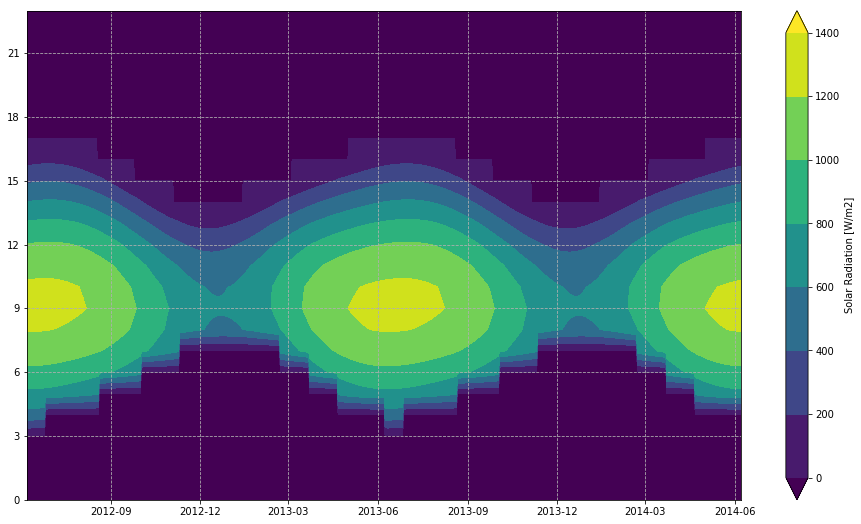

In [81]:
startdate = datetime(2012,6,7)
enddate = datetime(2014,6,7)

# lat, lon, azimuth, zenith of slope
df = solar_radiation_range(startdate, enddate, 48.6,16.3,90,30)

plt.figure(figsize=(16,9))
plt.contourf(df.index, df.columns,df.values.T, extend='both')
plt.colorbar(label='Solar Radiation [W/m2]')
plt.yticks(np.arange(0,24,3))
plt.grid(ls='--')